# Forecasting The Bachelorette

Build the best forecast for the Bachelorette IMDB ratings.

Our goal will be to predict how good the next episode of the Bachelorette is, that means we want a forecast horizon of  1
  episode.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

sns.set_style("whitegrid")

## 1. <a href="https://www.imdb.com/title/tt0348894/">The Bachelorette</a>

The data set we will work with is the IMDB ratings of every episode of the Bachelorette (as of May 2, 2023). This data was pulled with the `Cinemagoer` python IMDB API wrapper. 

In [4]:
tv=pd.read_csv('../../data/the_bachelorette.csv')

In [5]:
tv.head()

,episode_number,title,season,season_episode_number,imdb_rating
0,1,Episode #1.1,1,1,6.201235
1,2,Episode #1.2,1,2,6.201235
2,3,Episode #1.3,1,3,5.301235
3,4,Episode #1.4,1,4,5.801235
4,5,Episode #1.5,1,5,5.801235


Here are descriptions for the columns of the data:
- `episode_number` is the number of the episode with respect to the entire series run,
- `title` is the title of the episode,
- `season` is the number of the season in which the episode aired,
- `season_episode_number` is the number of the episode with respect to the season in which it aired,
- `imdb_rating` is the average rating of the episode among IMDB's users.

### a. train test split

sets aside the last three episodes as a test set.

In [7]:
tv_train=tv.iloc[:-3]
tv_test=tv[-3:]

### b.  exhibit a trend  or seasonality??

Plot the IMDB rating for each episode using the training data.


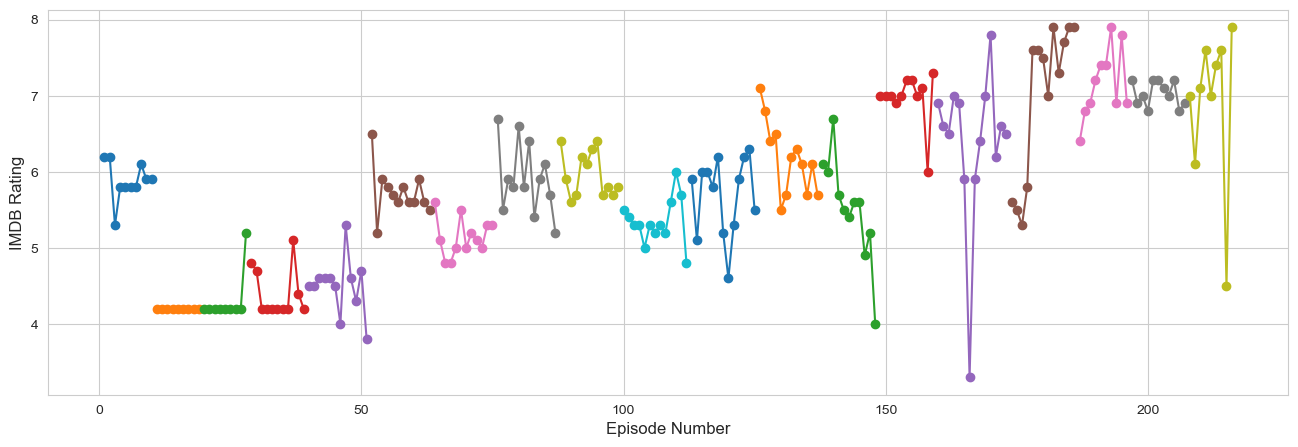

In [8]:
plt.figure(figsize=(16,5))

for season in range(1, tv_train.season.max()+1):
    plt.plot(tv_train.loc[tv_train.season == season].episode_number,
             tv_train.loc[tv_train.season == season].imdb_rating,
             '-o')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlabel("Episode Number", fontsize=12)
plt.ylabel("IMDB Rating", fontsize=12)

    
plt.show()

From the above plot we didn't see the seasonality but a upward trend.

## 2. Baseline Models

the following baseline models for non-seasonal data:
- The average forecast
- The naive forecast
- The trend forecast and
- The random walk with drift.

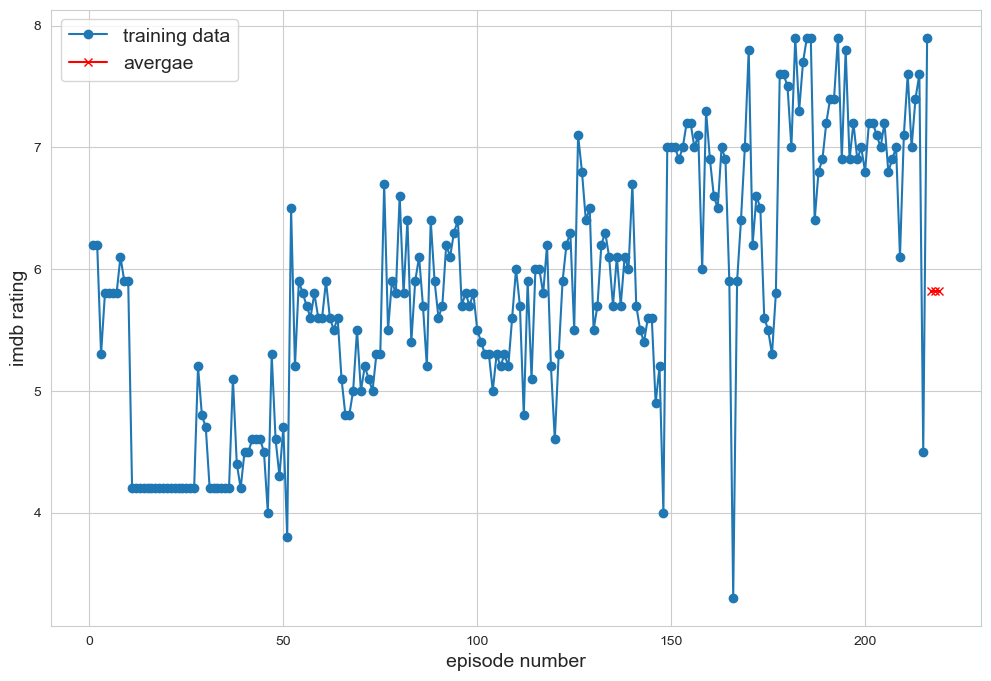

In [9]:
## the average forecast

plt.figure(figsize=(12,8))

plt.plot(tv_train.episode_number,
         tv_train.imdb_rating,
         '-o',
         label='training data')

plt.plot(range(tv_train.episode_number.max()+1, tv_train.episode_number.max()+4) ,
         np.ones(3)*tv_train.imdb_rating.mean(),
        'r',
         marker='x',
         label='avergae')
         
plt.legend(fontsize=14)
plt.xlabel('episode number', fontsize=14)
plt.ylabel('imdb rating', fontsize=14)
plt.show()


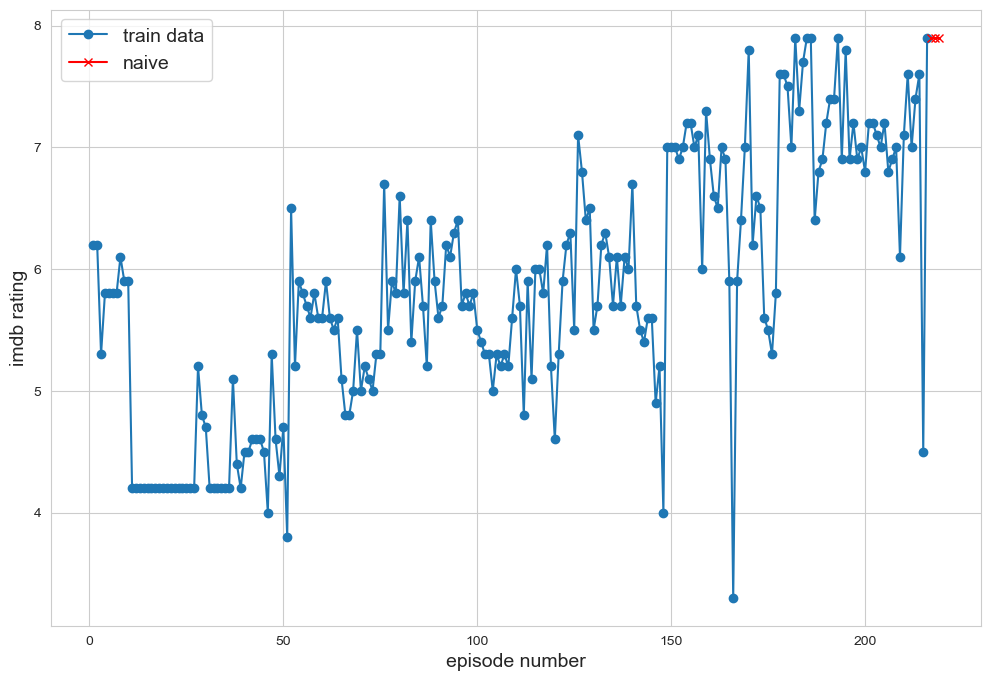

In [10]:
## the naive model

plt.figure(figsize=(12,8))

plt.plot(tv_train.episode_number,
         tv_train.imdb_rating,
         '-o',
         label='train data')

plt.plot(range(tv_train.episode_number.max()+1, tv_train.episode_number.max()+4) ,
         np.ones(3)*tv_train.imdb_rating.values[-1],
        'r',
         marker='x',
         label='naive')

plt.legend(fontsize=14)
plt.xlabel('episode number', fontsize=14)
plt.ylabel('imdb rating', fontsize=14)
plt.show()


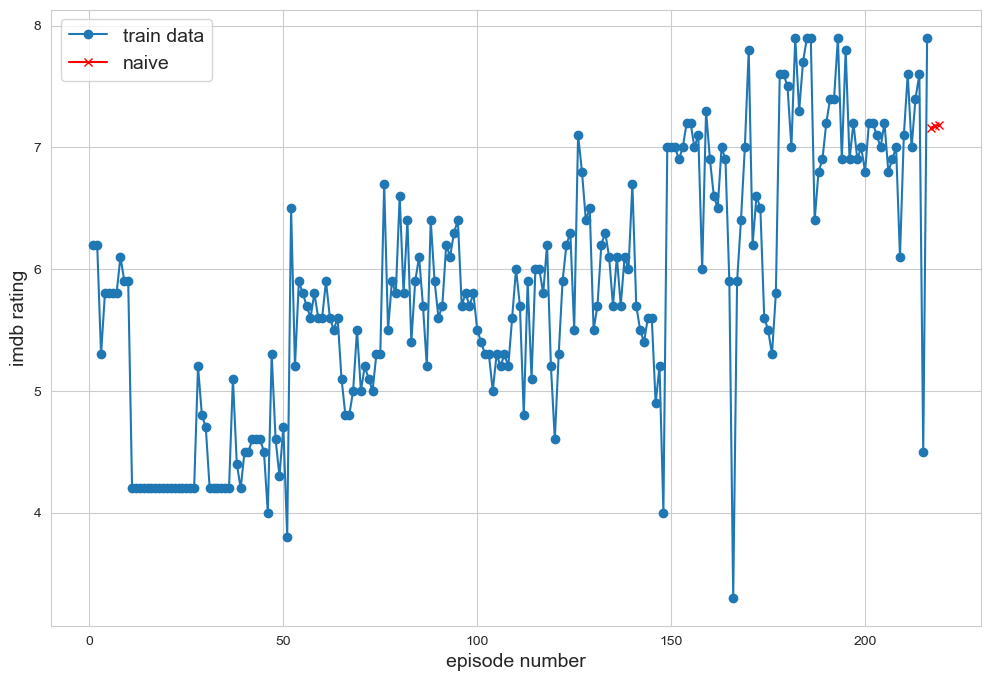

In [11]:
## The trend model
from sklearn.linear_model import LinearRegression

slr=LinearRegression()
slr.fit(tv_train.episode_number.values.reshape(-1,1),
        tv_train.imdb_rating)

plt.figure(figsize=(12,8))

plt.plot(tv_train.episode_number,
         tv_train.imdb_rating,
         '-o',
         label='train data')

plt.plot(np.arange(tv_train.episode_number.max()+1, tv_train.episode_number.max()+4) ,
         slr.predict(tv_test.episode_number.values.reshape(-1,1)),
        'r',
         marker='x',
         label='naive')

plt.legend(fontsize=14)
plt.xlabel('episode number', fontsize=14)
plt.ylabel('imdb rating', fontsize=14)
plt.show()

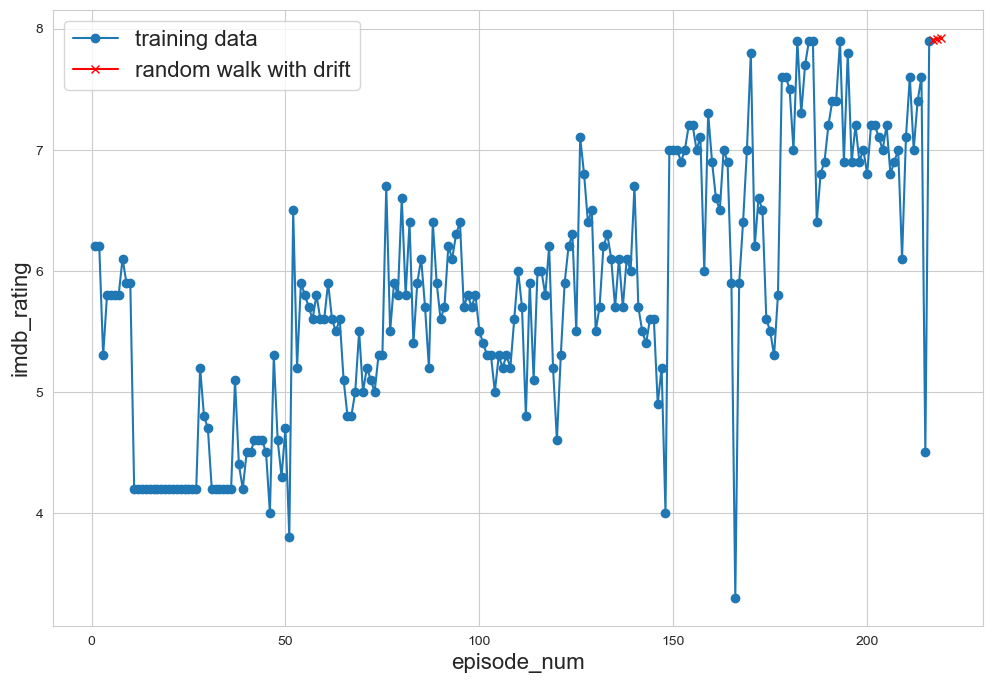

In [12]:
# The random walk with drift.
beta_hat=tv_train.imdb_rating.diff()[1:].mean()
pred=tv_train.imdb_rating.values[-1]+beta_hat*np.arange(1,len(tv_test)+1)

plt.figure(figsize=(12,8))

plt.plot(tv_train.episode_number,
         tv_train.imdb_rating,
         '-o',
         label='training data')

plt.plot(np.arange(tv_train.episode_number.max()+1, tv_train.episode_number.max()+4),
         pred,
         'r',
         marker='x',
         label='random walk with drift')

plt.legend(fontsize=16)
plt.xlabel('episode_num', fontsize=16)
plt.ylabel('imdb_rating', fontsize=16)
plt.show()

### a. cross-validation

Calculate the average cross-validation root mean squared error for baseline models. 

Set up this cross-validation so that there are ten splits and each holdout set only has three observations in it.


In [15]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [16]:
## Make the time series cv here
cv = TimeSeriesSplit(n_splits=10, 
                     test_size=3)

#### Average Model

In [17]:
## Make an array to hold the cv rmses here
rmses=np.zeros(10)

## loop through the cv splits here
i = 0
for train_index, test_index in cv.split(tv_train):
    ## Get the training and holdout sets
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    ## Fit your model/Make your prediction on the holdout set here
    pred=np.ones(3)*tv_tt.imdb_rating.mean()
    
    ## Record the rmse for the split here
    rmses[i]=np.sqrt(mean_squared_error(tv_ho.imdb_rating, pred))
    
    i = i + 1

In [18]:
np.mean(rmses,axis=0)

1.429883233159107

#### Naive model

In [19]:
naive_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    tt_naive = tv_tt.imdb_rating.values[-1]
    
    naive_rmses[i] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values,
                                    tt_naive*np.ones(3)))
    
    i = i + 1

In [20]:
np.mean(naive_rmses)

0.5962082745150036

#### Trend model

In [22]:
trend_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    slr = LinearRegression()
    
    slr.fit(tv_tt.episode_number.values.reshape(-1,1),
               tv_tt.imdb_rating)
    
    pred = slr.predict(tv_ho.episode_number.values.reshape(-1,1))
    
    trend_rmses[i] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values,
                                        pred))
    
    i += 1
    

In [23]:
np.mean(trend_rmses)

0.47290205472258784

#### Random walk with drift

In [24]:
walk_rmses = np.zeros(10)

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.loc[train_index]
    tv_ho = tv_train.loc[test_index]
    
    beta_hat = tv_tt.imdb_rating.diff().mean()
    
    pred = tv_tt.imdb_rating.values[-1] + beta_hat*np.array([1,2,3])
    
    walk_rmses[i] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values,
                                        pred))
    
    i = i + 1

In [25]:
np.mean(walk_rmses)

0.5995732550265304

## moving average model

In this problem you will be tuning the moving average window size,  𝑞
 , to find the value that minimizes the average cross-validation root mean squared error (RMSE).

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [27]:
cv = TimeSeriesSplit(10, test_size=3)

start = 2
end = 31
ma_rmses = np.zeros((10, len(range(start, end))))


i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for q in range(start, end):
        pred = tv_tt.imdb_rating[-q:].mean() * np.ones(len(tv_ho))
        
        ma_rmses[i,j] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values, pred))
        j = j + 1
    i = i + 1

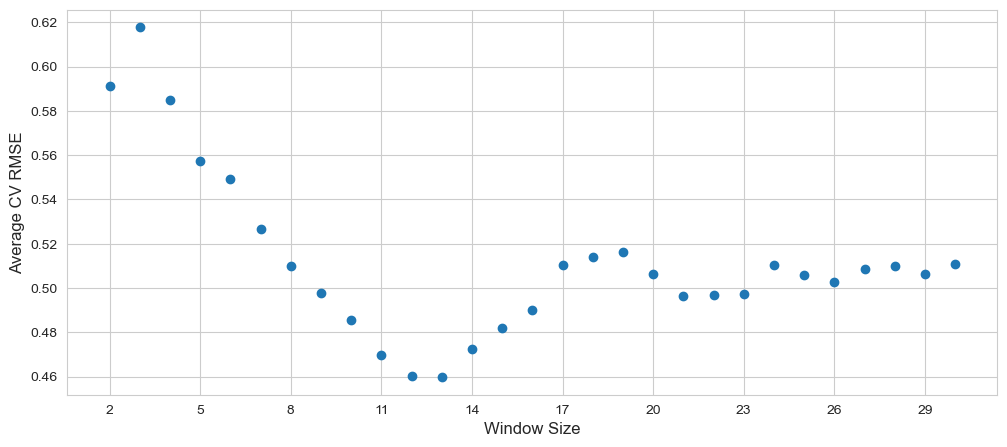

In [28]:
plt.figure(figsize=(12,5))

plt.scatter(range(start,end), np.mean(ma_rmses, axis=0))

plt.xlabel("Window Size", fontsize=12)
plt.ylabel("Average CV RMSE", fontsize=12)

plt.xticks(range(start, end, 3), fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [29]:
print("The window size that minimized the avg. cv rmse",
      "was q =", 
      range(start,end)[np.argmin(np.mean(ma_rmses, axis=0))],
      "\b.",
      "It had a mean cv rmse of", 
      np.round(np.min(np.mean(ma_rmses, axis=0)), 3))

The window size that minimized the avg. cv rmse was q = 13 . It had a mean cv rmse of 0.46


## exponential smoothing model.

Because these data exhibit a trend but not seasonality we will fit a double exponential smoothing model. For this we will want to find the best  𝛼
  (The smoothing on the time series) and  𝛽
  (the smoothing on the trend component).

In [30]:
from statsmodels.tsa.holtwinters import Holt

In [31]:
exp_rmses = np.zeros((10, len(np.arange(0, 0.2, .01)), len(np.arange(0, 0.2, .01))))

i = 0
for train_index, test_index in cv.split(tv_train):
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for alpha in np.arange(0, 0.2, .01):
        k = 0
        for beta in np.arange(0, 0.2, .01):
            print("alpha =", alpha,
                     "beta =", beta)

            exp_smooth = Holt(tv_tt.imdb_rating.values).fit(smoothing_level=alpha, 
                                                                      smoothing_trend=beta,
                                                                      optimized=False)

            exp_rmses[i,j,k] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values, 
                                                          exp_smooth.forecast(len(tv_ho))))
            k = k + 1
        j = j + 1
    i = i + 1

alpha = 0.0 beta = 0.0
alpha = 0.0 beta = 0.01
alpha = 0.0 beta = 0.02
alpha = 0.0 beta = 0.03
alpha = 0.0 beta = 0.04
alpha = 0.0 beta = 0.05
alpha = 0.0 beta = 0.06
alpha = 0.0 beta = 0.07
alpha = 0.0 beta = 0.08
alpha = 0.0 beta = 0.09
alpha = 0.0 beta = 0.1
alpha = 0.0 beta = 0.11
alpha = 0.0 beta = 0.12
alpha = 0.0 beta = 0.13
alpha = 0.0 beta = 0.14
alpha = 0.0 beta = 0.15
alpha = 0.0 beta = 0.16
alpha = 0.0 beta = 0.17
alpha = 0.0 beta = 0.18
alpha = 0.0 beta = 0.19
alpha = 0.01 beta = 0.0
alpha = 0.01 beta = 0.01
alpha = 0.01 beta = 0.02
alpha = 0.01 beta = 0.03
alpha = 0.01 beta = 0.04
alpha = 0.01 beta = 0.05
alpha = 0.01 beta = 0.06
alpha = 0.01 beta = 0.07
alpha = 0.01 beta = 0.08
alpha = 0.01 beta = 0.09
alpha = 0.01 beta = 0.1
alpha = 0.01 beta = 0.11
alpha = 0.01 beta = 0.12
alpha = 0.01 beta = 0.13
alpha = 0.01 beta = 0.14
alpha = 0.01 beta = 0.15
alpha = 0.01 beta = 0.16
alpha = 0.01 beta = 0.17
alpha = 0.01 beta = 0.18
alpha = 0.01 beta = 0.19
alpha = 0.02 beta = 0.0


alpha = 0.18 beta = 0.03
alpha = 0.18 beta = 0.04
alpha = 0.18 beta = 0.05
alpha = 0.18 beta = 0.06
alpha = 0.18 beta = 0.07
alpha = 0.18 beta = 0.08
alpha = 0.18 beta = 0.09
alpha = 0.18 beta = 0.1
alpha = 0.18 beta = 0.11
alpha = 0.18 beta = 0.12
alpha = 0.18 beta = 0.13
alpha = 0.18 beta = 0.14
alpha = 0.18 beta = 0.15
alpha = 0.18 beta = 0.16
alpha = 0.18 beta = 0.17
alpha = 0.18 beta = 0.18
alpha = 0.18 beta = 0.19
alpha = 0.19 beta = 0.0
alpha = 0.19 beta = 0.01
alpha = 0.19 beta = 0.02
alpha = 0.19 beta = 0.03
alpha = 0.19 beta = 0.04
alpha = 0.19 beta = 0.05
alpha = 0.19 beta = 0.06
alpha = 0.19 beta = 0.07
alpha = 0.19 beta = 0.08
alpha = 0.19 beta = 0.09
alpha = 0.19 beta = 0.1
alpha = 0.19 beta = 0.11
alpha = 0.19 beta = 0.12
alpha = 0.19 beta = 0.13
alpha = 0.19 beta = 0.14
alpha = 0.19 beta = 0.15
alpha = 0.19 beta = 0.16
alpha = 0.19 beta = 0.17
alpha = 0.19 beta = 0.18
alpha = 0.19 beta = 0.19
alpha = 0.0 beta = 0.0
alpha = 0.0 beta = 0.01
alpha = 0.0 beta = 0.02
alpha =

alpha = 0.15 beta = 0.16
alpha = 0.15 beta = 0.17
alpha = 0.15 beta = 0.18
alpha = 0.15 beta = 0.19
alpha = 0.16 beta = 0.0
alpha = 0.16 beta = 0.01
alpha = 0.16 beta = 0.02
alpha = 0.16 beta = 0.03
alpha = 0.16 beta = 0.04
alpha = 0.16 beta = 0.05
alpha = 0.16 beta = 0.06
alpha = 0.16 beta = 0.07
alpha = 0.16 beta = 0.08
alpha = 0.16 beta = 0.09
alpha = 0.16 beta = 0.1
alpha = 0.16 beta = 0.11
alpha = 0.16 beta = 0.12
alpha = 0.16 beta = 0.13
alpha = 0.16 beta = 0.14
alpha = 0.16 beta = 0.15
alpha = 0.16 beta = 0.16
alpha = 0.16 beta = 0.17
alpha = 0.16 beta = 0.18
alpha = 0.16 beta = 0.19
alpha = 0.17 beta = 0.0
alpha = 0.17 beta = 0.01
alpha = 0.17 beta = 0.02
alpha = 0.17 beta = 0.03
alpha = 0.17 beta = 0.04
alpha = 0.17 beta = 0.05
alpha = 0.17 beta = 0.06
alpha = 0.17 beta = 0.07
alpha = 0.17 beta = 0.08
alpha = 0.17 beta = 0.09
alpha = 0.17 beta = 0.1
alpha = 0.17 beta = 0.11
alpha = 0.17 beta = 0.12
alpha = 0.17 beta = 0.13
alpha = 0.17 beta = 0.14
alpha = 0.17 beta = 0.15
alph

alpha = 0.13 beta = 0.0
alpha = 0.13 beta = 0.01
alpha = 0.13 beta = 0.02
alpha = 0.13 beta = 0.03
alpha = 0.13 beta = 0.04
alpha = 0.13 beta = 0.05
alpha = 0.13 beta = 0.06
alpha = 0.13 beta = 0.07
alpha = 0.13 beta = 0.08
alpha = 0.13 beta = 0.09
alpha = 0.13 beta = 0.1
alpha = 0.13 beta = 0.11
alpha = 0.13 beta = 0.12
alpha = 0.13 beta = 0.13
alpha = 0.13 beta = 0.14
alpha = 0.13 beta = 0.15
alpha = 0.13 beta = 0.16
alpha = 0.13 beta = 0.17
alpha = 0.13 beta = 0.18
alpha = 0.13 beta = 0.19
alpha = 0.14 beta = 0.0
alpha = 0.14 beta = 0.01
alpha = 0.14 beta = 0.02
alpha = 0.14 beta = 0.03
alpha = 0.14 beta = 0.04
alpha = 0.14 beta = 0.05
alpha = 0.14 beta = 0.06
alpha = 0.14 beta = 0.07
alpha = 0.14 beta = 0.08
alpha = 0.14 beta = 0.09
alpha = 0.14 beta = 0.1
alpha = 0.14 beta = 0.11
alpha = 0.14 beta = 0.12
alpha = 0.14 beta = 0.13
alpha = 0.14 beta = 0.14
alpha = 0.14 beta = 0.15
alpha = 0.14 beta = 0.16
alpha = 0.14 beta = 0.17
alpha = 0.14 beta = 0.18
alpha = 0.14 beta = 0.19
alph

alpha = 0.11 beta = 0.09
alpha = 0.11 beta = 0.1
alpha = 0.11 beta = 0.11
alpha = 0.11 beta = 0.12
alpha = 0.11 beta = 0.13
alpha = 0.11 beta = 0.14
alpha = 0.11 beta = 0.15
alpha = 0.11 beta = 0.16
alpha = 0.11 beta = 0.17
alpha = 0.11 beta = 0.18
alpha = 0.11 beta = 0.19
alpha = 0.12 beta = 0.0
alpha = 0.12 beta = 0.01
alpha = 0.12 beta = 0.02
alpha = 0.12 beta = 0.03
alpha = 0.12 beta = 0.04
alpha = 0.12 beta = 0.05
alpha = 0.12 beta = 0.06
alpha = 0.12 beta = 0.07
alpha = 0.12 beta = 0.08
alpha = 0.12 beta = 0.09
alpha = 0.12 beta = 0.1
alpha = 0.12 beta = 0.11
alpha = 0.12 beta = 0.12
alpha = 0.12 beta = 0.13
alpha = 0.12 beta = 0.14
alpha = 0.12 beta = 0.15
alpha = 0.12 beta = 0.16
alpha = 0.12 beta = 0.17
alpha = 0.12 beta = 0.18
alpha = 0.12 beta = 0.19
alpha = 0.13 beta = 0.0
alpha = 0.13 beta = 0.01
alpha = 0.13 beta = 0.02
alpha = 0.13 beta = 0.03
alpha = 0.13 beta = 0.04
alpha = 0.13 beta = 0.05
alpha = 0.13 beta = 0.06
alpha = 0.13 beta = 0.07
alpha = 0.13 beta = 0.08
alph

alpha = 0.11 beta = 0.07
alpha = 0.11 beta = 0.08
alpha = 0.11 beta = 0.09
alpha = 0.11 beta = 0.1
alpha = 0.11 beta = 0.11
alpha = 0.11 beta = 0.12
alpha = 0.11 beta = 0.13
alpha = 0.11 beta = 0.14
alpha = 0.11 beta = 0.15
alpha = 0.11 beta = 0.16
alpha = 0.11 beta = 0.17
alpha = 0.11 beta = 0.18
alpha = 0.11 beta = 0.19
alpha = 0.12 beta = 0.0
alpha = 0.12 beta = 0.01
alpha = 0.12 beta = 0.02
alpha = 0.12 beta = 0.03
alpha = 0.12 beta = 0.04
alpha = 0.12 beta = 0.05
alpha = 0.12 beta = 0.06
alpha = 0.12 beta = 0.07
alpha = 0.12 beta = 0.08
alpha = 0.12 beta = 0.09
alpha = 0.12 beta = 0.1
alpha = 0.12 beta = 0.11
alpha = 0.12 beta = 0.12
alpha = 0.12 beta = 0.13
alpha = 0.12 beta = 0.14
alpha = 0.12 beta = 0.15
alpha = 0.12 beta = 0.16
alpha = 0.12 beta = 0.17
alpha = 0.12 beta = 0.18
alpha = 0.12 beta = 0.19
alpha = 0.13 beta = 0.0
alpha = 0.13 beta = 0.01
alpha = 0.13 beta = 0.02
alpha = 0.13 beta = 0.03
alpha = 0.13 beta = 0.04
alpha = 0.13 beta = 0.05
alpha = 0.13 beta = 0.06
alph

alpha = 0.1 beta = 0.05
alpha = 0.1 beta = 0.06
alpha = 0.1 beta = 0.07
alpha = 0.1 beta = 0.08
alpha = 0.1 beta = 0.09
alpha = 0.1 beta = 0.1
alpha = 0.1 beta = 0.11
alpha = 0.1 beta = 0.12
alpha = 0.1 beta = 0.13
alpha = 0.1 beta = 0.14
alpha = 0.1 beta = 0.15
alpha = 0.1 beta = 0.16
alpha = 0.1 beta = 0.17
alpha = 0.1 beta = 0.18
alpha = 0.1 beta = 0.19
alpha = 0.11 beta = 0.0
alpha = 0.11 beta = 0.01
alpha = 0.11 beta = 0.02
alpha = 0.11 beta = 0.03
alpha = 0.11 beta = 0.04
alpha = 0.11 beta = 0.05
alpha = 0.11 beta = 0.06
alpha = 0.11 beta = 0.07
alpha = 0.11 beta = 0.08
alpha = 0.11 beta = 0.09
alpha = 0.11 beta = 0.1
alpha = 0.11 beta = 0.11
alpha = 0.11 beta = 0.12
alpha = 0.11 beta = 0.13
alpha = 0.11 beta = 0.14
alpha = 0.11 beta = 0.15
alpha = 0.11 beta = 0.16
alpha = 0.11 beta = 0.17
alpha = 0.11 beta = 0.18
alpha = 0.11 beta = 0.19
alpha = 0.12 beta = 0.0
alpha = 0.12 beta = 0.01
alpha = 0.12 beta = 0.02
alpha = 0.12 beta = 0.03
alpha = 0.12 beta = 0.04
alpha = 0.12 beta =

alpha = 0.08 beta = 0.18
alpha = 0.08 beta = 0.19
alpha = 0.09 beta = 0.0
alpha = 0.09 beta = 0.01
alpha = 0.09 beta = 0.02
alpha = 0.09 beta = 0.03
alpha = 0.09 beta = 0.04
alpha = 0.09 beta = 0.05
alpha = 0.09 beta = 0.06
alpha = 0.09 beta = 0.07
alpha = 0.09 beta = 0.08
alpha = 0.09 beta = 0.09
alpha = 0.09 beta = 0.1
alpha = 0.09 beta = 0.11
alpha = 0.09 beta = 0.12
alpha = 0.09 beta = 0.13
alpha = 0.09 beta = 0.14
alpha = 0.09 beta = 0.15
alpha = 0.09 beta = 0.16
alpha = 0.09 beta = 0.17
alpha = 0.09 beta = 0.18
alpha = 0.09 beta = 0.19
alpha = 0.1 beta = 0.0
alpha = 0.1 beta = 0.01
alpha = 0.1 beta = 0.02
alpha = 0.1 beta = 0.03
alpha = 0.1 beta = 0.04
alpha = 0.1 beta = 0.05
alpha = 0.1 beta = 0.06
alpha = 0.1 beta = 0.07
alpha = 0.1 beta = 0.08
alpha = 0.1 beta = 0.09
alpha = 0.1 beta = 0.1
alpha = 0.1 beta = 0.11
alpha = 0.1 beta = 0.12
alpha = 0.1 beta = 0.13
alpha = 0.1 beta = 0.14
alpha = 0.1 beta = 0.15
alpha = 0.1 beta = 0.16
alpha = 0.1 beta = 0.17
alpha = 0.1 beta = 0.1

alpha = 0.07 beta = 0.04
alpha = 0.07 beta = 0.05
alpha = 0.07 beta = 0.06
alpha = 0.07 beta = 0.07
alpha = 0.07 beta = 0.08
alpha = 0.07 beta = 0.09
alpha = 0.07 beta = 0.1
alpha = 0.07 beta = 0.11
alpha = 0.07 beta = 0.12
alpha = 0.07 beta = 0.13
alpha = 0.07 beta = 0.14
alpha = 0.07 beta = 0.15
alpha = 0.07 beta = 0.16
alpha = 0.07 beta = 0.17
alpha = 0.07 beta = 0.18
alpha = 0.07 beta = 0.19
alpha = 0.08 beta = 0.0
alpha = 0.08 beta = 0.01
alpha = 0.08 beta = 0.02
alpha = 0.08 beta = 0.03
alpha = 0.08 beta = 0.04
alpha = 0.08 beta = 0.05
alpha = 0.08 beta = 0.06
alpha = 0.08 beta = 0.07
alpha = 0.08 beta = 0.08
alpha = 0.08 beta = 0.09
alpha = 0.08 beta = 0.1
alpha = 0.08 beta = 0.11
alpha = 0.08 beta = 0.12
alpha = 0.08 beta = 0.13
alpha = 0.08 beta = 0.14
alpha = 0.08 beta = 0.15
alpha = 0.08 beta = 0.16
alpha = 0.08 beta = 0.17
alpha = 0.08 beta = 0.18
alpha = 0.08 beta = 0.19
alpha = 0.09 beta = 0.0
alpha = 0.09 beta = 0.01
alpha = 0.09 beta = 0.02
alpha = 0.09 beta = 0.03
alph

alpha = 0.05 beta = 0.16
alpha = 0.05 beta = 0.17
alpha = 0.05 beta = 0.18
alpha = 0.05 beta = 0.19
alpha = 0.06 beta = 0.0
alpha = 0.06 beta = 0.01
alpha = 0.06 beta = 0.02
alpha = 0.06 beta = 0.03
alpha = 0.06 beta = 0.04
alpha = 0.06 beta = 0.05
alpha = 0.06 beta = 0.06
alpha = 0.06 beta = 0.07
alpha = 0.06 beta = 0.08
alpha = 0.06 beta = 0.09
alpha = 0.06 beta = 0.1
alpha = 0.06 beta = 0.11
alpha = 0.06 beta = 0.12
alpha = 0.06 beta = 0.13
alpha = 0.06 beta = 0.14
alpha = 0.06 beta = 0.15
alpha = 0.06 beta = 0.16
alpha = 0.06 beta = 0.17
alpha = 0.06 beta = 0.18
alpha = 0.06 beta = 0.19
alpha = 0.07 beta = 0.0
alpha = 0.07 beta = 0.01
alpha = 0.07 beta = 0.02
alpha = 0.07 beta = 0.03
alpha = 0.07 beta = 0.04
alpha = 0.07 beta = 0.05
alpha = 0.07 beta = 0.06
alpha = 0.07 beta = 0.07
alpha = 0.07 beta = 0.08
alpha = 0.07 beta = 0.09
alpha = 0.07 beta = 0.1
alpha = 0.07 beta = 0.11
alpha = 0.07 beta = 0.12
alpha = 0.07 beta = 0.13
alpha = 0.07 beta = 0.14
alpha = 0.07 beta = 0.15
alph

alpha = 0.03 beta = 0.07
alpha = 0.03 beta = 0.08
alpha = 0.03 beta = 0.09
alpha = 0.03 beta = 0.1
alpha = 0.03 beta = 0.11
alpha = 0.03 beta = 0.12
alpha = 0.03 beta = 0.13
alpha = 0.03 beta = 0.14
alpha = 0.03 beta = 0.15
alpha = 0.03 beta = 0.16
alpha = 0.03 beta = 0.17
alpha = 0.03 beta = 0.18
alpha = 0.03 beta = 0.19
alpha = 0.04 beta = 0.0
alpha = 0.04 beta = 0.01
alpha = 0.04 beta = 0.02
alpha = 0.04 beta = 0.03
alpha = 0.04 beta = 0.04
alpha = 0.04 beta = 0.05
alpha = 0.04 beta = 0.06
alpha = 0.04 beta = 0.07
alpha = 0.04 beta = 0.08
alpha = 0.04 beta = 0.09
alpha = 0.04 beta = 0.1
alpha = 0.04 beta = 0.11
alpha = 0.04 beta = 0.12
alpha = 0.04 beta = 0.13
alpha = 0.04 beta = 0.14
alpha = 0.04 beta = 0.15
alpha = 0.04 beta = 0.16
alpha = 0.04 beta = 0.17
alpha = 0.04 beta = 0.18
alpha = 0.04 beta = 0.19
alpha = 0.05 beta = 0.0
alpha = 0.05 beta = 0.01
alpha = 0.05 beta = 0.02
alpha = 0.05 beta = 0.03
alpha = 0.05 beta = 0.04
alpha = 0.05 beta = 0.05
alpha = 0.05 beta = 0.06
alph

In [33]:
## This gives us the indices of the smallest avg cv rmse
exp_ind = np.unravel_index(np.argmin(np.mean(exp_rmses, axis=0), axis=None), 
                           np.mean(exp_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(exp_rmses, axis=0), axis=None), 
                 np.mean(exp_rmses, axis=0).shape)

(1, 14)

In [34]:
print("The alpha and beta values that give a double exponential",
         "smoothing model with lowest avg cv rmse are",
         "alpha = ", np.arange(0, 0.2, .01)[exp_ind[0]],
         "and beta = ", np.arange(0, 0.2, .01)[exp_ind[1]])

print("This model had an avg cv rmse of",
         np.round(np.mean(exp_rmses, axis=0)[exp_ind],3))

The alpha and beta values that give a double exponential smoothing model with lowest avg cv rmse are alpha =  0.01 and beta =  0.14
This model had an avg cv rmse of 0.453


## ARIMA model.

First let's check the stationarity assumption for this time series. Make an autocorrelation plot of the training data. If you find that the ACF plot indicates that the time series is non-stationary, plot the ACF of the time series' first differences. 

In [35]:
import statsmodels.api as sm

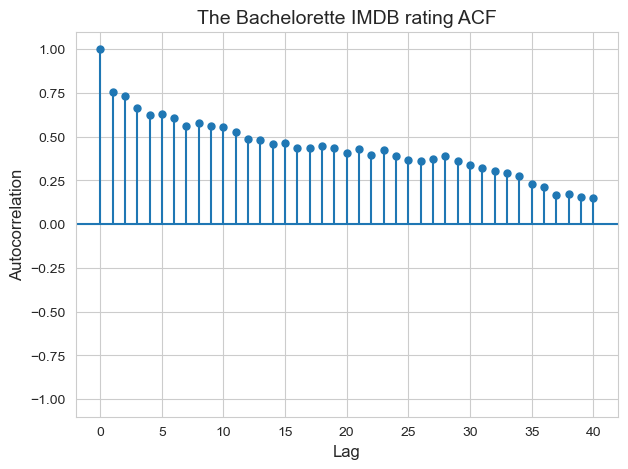

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

sm.graphics.tsa.plot_acf(tv_train.imdb_rating.values,
                            alpha=None,
                            lags = 40,
                            ax = ax)

plt.title('The Bachelorette IMDB rating ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

you see a correlogram that has high (in magnitude) autocorrelation values over a long range of lags this is indicative of a time series that is not stationary. Importantly, seing a time series with a correlogram like this does not necessarily imply that the time series in question exhibits a trend, just that it is not stationary.

We can perform differencing quickly with a the .diff() function in pandas, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.diff.html.

For non-seasonal data a single difference is typically sufficient to produce a stationary time series.

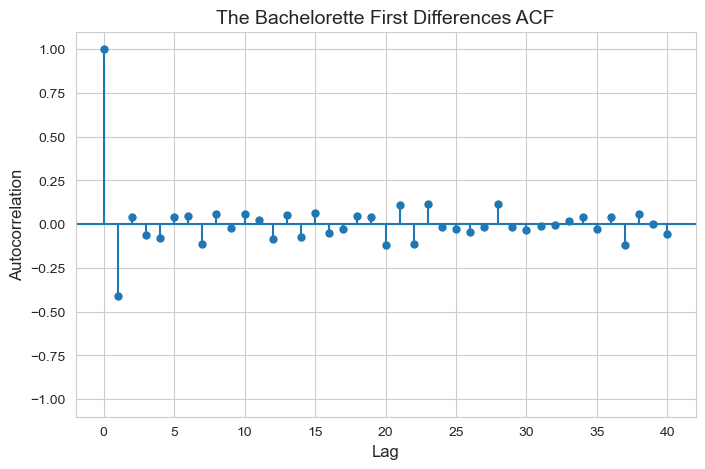

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

sm.graphics.tsa.plot_acf(tv_train.imdb_rating.diff().values[1:],
                               alpha=None,
                               lags=40,
                               ax=ax)

plt.title('The Bachelorette First Differences ACF', fontsize=14)
plt.ylabel("Autocorrelation", fontsize=12)
plt.xlabel("Lag", fontsize=12)

plt.ylim(-1.1,1.1)

plt.show()

From we saw that above, Set $d$ to 1 and then perform hyperparameter tuning to find the values of $p$ and $q$ that give us the lowest mean CV RMSE.

### tuning hyperparametr p and q

In [38]:
from statsmodels.tsa.api import SARIMAX

In [39]:
# to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [40]:
arima_rmses = np.zeros((10, 4, 4))

i = 0
for train_index, test_index in cv.split(tv_train):
    ### NOTE THE ORIGINAL COPY HAD A TYPO
    ### should be iloc not loc
    tv_tt = tv_train.iloc[train_index]
    tv_ho = tv_train.iloc[test_index]
    
    j = 0
    for p in range(4):
        k = 0
        for q in range(4):
            arima = SARIMAX(tv_tt.imdb_rating.values,
                               order=(p, 1, q)).fit(maxiter=500)
            
            arima_rmses[i,j,k] = np.sqrt(mean_squared_error(tv_ho.imdb_rating.values, 
                                                   arima.forecast(len(tv_ho))))
            k = k +1
        j = j + 1
    i = i +1

In [41]:
arima_ind = np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                             np.mean(arima_rmses, axis=0).shape)
np.unravel_index(np.argmin(np.mean(arima_rmses, axis=0), axis=None), 
                 np.mean(arima_rmses, axis=0).shape)

(1, 3)

In [42]:
print("The p and q values that give an ARIMA model",
         "with lowest avg cv mse are",
         "p = ", range(4)[arima_ind[0]],
         "and q = ", range(4)[arima_ind[1]])

print("This model had an avg cv mse of",
         np.round(np.mean(arima_rmses, axis=0)[arima_ind],3))

The p and q values that give an ARIMA model with lowest avg cv mse are p =  1 and q =  3
This model had an avg cv mse of 0.529


## Model comparison
 which one has the best RMSE?

In [43]:
pd.DataFrame({'Model': ['Baseline(average)', 'Baseline(Naive)', 'Baseline(Trend)', 'Baseline(Random Walk with shift)',
                        'Moving Average', 'Double Exponential Smoothing', 'Arima'],
                   'RMSE': [1.429, 0.473, 0.596, 0.599, 0.460, 0.453, 0.529]}).sort_values('RMSE')

,Model,RMSE
5,Double Exponential Smoothing,0.453
4,Moving Average,0.460
1,Baseline(Naive),0.473
6,Arima,0.529
2,Baseline(Trend),0.596
3,Baseline(Random Walk with shift),0.599
0,Baseline(average),1.429


## Plot the best forecast with the training and test data.

In [46]:
holt = Holt(tv_train.imdb_rating.values).fit(smoothing_level=.01, 
                                              smoothing_trend=.14,
                                              optimized=False)

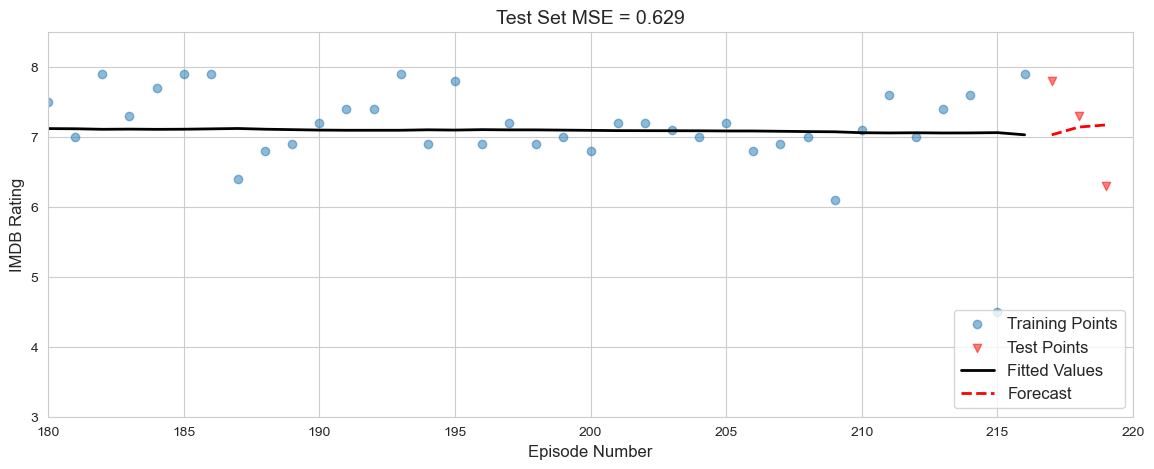

In [47]:
plt.figure(figsize=(14,5))

plt.scatter(tv_train.episode_number,
               tv_train.imdb_rating,
               alpha=.5,
               label="Training Points")

plt.scatter(tv_test.episode_number,
               tv_test.imdb_rating,
               alpha=.5,
               c = 'red',
               marker = 'v',
               label="Test Points")

plt.plot(tv_train.episode_number,
            holt.fittedvalues,
            'k-',
            linewidth = 2,
            label="Fitted Values")

plt.plot(tv_test.episode_number,
            arima.forecast(len(tv_test)),
            'r--',
            linewidth=2,
            label="Forecast")

plt.legend(fontsize=12, loc=4)

test_mse = np.sqrt(mean_squared_error(tv_test.imdb_rating.values, 
                                       holt.forecast(len(tv_test))))

plt.title("Test Set MSE = " + str(np.round(test_mse,3)),
             fontsize=14)

plt.xlabel("Episode Number", fontsize=12)
plt.ylabel("IMDB Rating", fontsize=12)


plt.ylim(3,8.5)
plt.xlim(180,220)

plt.show()